In [221]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pymc as pm
import os
import sys
sys.path.append(os.path.abspath('../src'))
from data_tools import data_utils

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [222]:
project_dir = project_dir = Path.cwd().parent
trunc_D = 10

data_utils.create_data_split(
    start_year=2013,
    end_year=2020,
    D=trunc_D,
    data_folder_path = project_dir / "data",
    input_filename="DENGSP.csv",
    train_prop=0.7,
    val_prop=0.2,
    test_prop=0.1
)

/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/src/data_tools/data_utils.py:19: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf_raw = pd.read_csv(input_data_path, index_col=0)


In [223]:


%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 8998
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-darkgrid")

def sampler_kwargs():
    return dict(
        nuts_sampler="nutpie",
        chains=2,
        draws=300,
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"},
        progressbar=False
    )

train_df = pd.read_csv(project_dir / "data" / "model" / "training_data.csv",
    parse_dates=True,
    date_format="%Y %b",
    index_col=0,
    dtype={"value": float},
)
y_true = train_df.sum(axis=1)
y_true.index = pd.to_datetime(y_true.index)
y_true.index.freq = y_true.index.inferred_freq
y_true

print(y_true.min())

55


In [27]:
train_df

,delay_0,delay_1,delay_2,delay_3,delay_4,delay_5,delay_6,delay_7,delay_8,delay_9
Date_Symptoms,,,,,,,,,,
2013-01-11,53,55,35,116,64,54,65,39,1,1
2013-01-12,30,56,110,91,63,61,62,7,4,37
2013-01-13,21,113,100,70,69,55,8,8,71,25
2013-01-14,47,105,99,105,80,25,14,131,47,21
2013-01-15,51,119,87,70,28,23,115,66,29,19
...,...,...,...,...,...,...,...,...,...,...
2018-07-30,14,20,17,13,11,2,2,12,5,3
2018-07-31,7,20,13,12,4,3,2,2,2,0
2018-08-01,5,18,11,8,3,16,6,3,3,3


In [224]:
def mask_matrix(matrix, D):
        masked_matrix = matrix.copy()
        nrow, ncol = masked_matrix.shape

        for i in range(nrow):
            for j in range(ncol):
                if i + j > D - 1:
                     masked_matrix[i, j] = False
        return  masked_matrix


def create_fourier_features(t, n, p=365.25):
    x = 2 * np.pi * (pt.arange(n)+1) * t[:, None] / p
    return pt.concatenate((pt.cos(x), pt.sin(x)), axis = 1)


In [ ]:
def proportion_net(Z_data, n_hidden, output_dim):
    T,D = Z_data.shape
    # Prior
    W1_net = pm.Normal("W1_net", mu=0, sigma=1, shape=(D, n_hidden))
    b1_net = pm.Normal("b1_net", mu=0, sigma=1, shape=(n_hidden,))

    W2_net = pm.Normal("W2_net", mu=0, sigma=1, shape=(n_hidden, n_hidden))
    b2_net = pm.Normal("b2_net", mu=0, sigma=1, shape=(n_hidden,))
    
    W3_net = pm.Normal("W3_net", mu=0, sigma=1, shape=(n_hidden, output_dim))
    b3_net = pm.Normal("b3_net", mu=0, sigma=1, shape=(output_dim,))
    
    # Forward pass
    h1 = pm.math.tanh(pm.math.dot(Z_data, W1_net) + b1_net)  # shape (T, n_hidden)
    h2 = pm.math.tanh(pm.math.dot(h1, W2_net) + b2_net)
    p_raw = pm.math.dot(h2, W3_net) + b3_net  # shape (T, D)
    
    return p_raw
    
    return p_raw
def get_GP_nowcast(Z_data, model_D, mask):
    t = np.arange(0, len(Z_data))
    t_min = t.min()
    t_max= t.max()
    t_scaled = (t - t_min) / (t_max - t_min)

    with pm.Model() as dir_model:
        t_shared = pm.Data("t", t_scaled)
        Z_shared = pm.Data("Z_data", Z_data)

        # Linear trend parameters
        b0 = pm.Normal("b0", mu=0, sigma=1)   # intercept
        b1 = pm.Normal("b1", mu=0, sigma=1)
        
        log_lam = b0 = b1*t_shared
        lam = pm.Deterministic("lam", pm.math.exp(log_lam))

        
        p = pm.Dirichlet("p", a=np.ones(model_D))

        # p_raw = proportion_net(Z_shared, n_hidden=10, output_dim=model_D)
        # p = pm.Deterministic("p", pm.math.softmax(p_raw, axis=0))

        # Create matrix of lam[t,:] * p[t,d]
        mu = lam[:, None] * p[None, :]

        alpha = pm.HalfNormal("alpha", sigma=2)
        z = pm.NegativeBinomial("z", mu[mask], alpha, observed=Z_data[mask])

        idata = pm.sample(nuts_sampler="numpyro", progressbar=False)
        
    lam_post_samples = az.extract(idata, group="posterior", num_samples=1000)["lam"]
    return lam_post_samples[-1,:].median()

In [235]:
from joblib import Parallel, delayed
import numpy as np

M=0
model_D=10
n_points = 10
Z_model_data = train_df.copy().iloc[0:n_points+M+model_D, 0:model_D]

def safe_fit_model(t):
    try:
        print(t-M-model_D)
        Z_data = Z_model_data.values[t-M-model_D: t].copy()
        mask = np.ones_like(Z_data, dtype=bool)
        mask[-model_D:] = mask_matrix(np.array(mask[-model_D:]), model_D)
        Z_data[~mask] = 0
        
        print(Z_data)
        result = get_GP_nowcast(Z_data, model_D, mask)
        return result
    except Exception as e:
        print(f"Error in fit at t={t}: {e}")
        return None

# number of cores you want
n_jobs = 4

results = Parallel(n_jobs=n_jobs, backend="loky")(
    delayed(safe_fit_model)(t)
    for t in range(M+model_D, len(Z_model_data))
)

0
[[ 53  55  35 116  64  54  65  39   1   1]
 [ 30  56 110  91  63  61  62   7   4   0]
 [ 21 113 100  70  69  55   8   8   0   0]
 [ 47 105  99 105  80  25  14   0   0   0]
 [ 51 119  87  70  28  23   0   0   0   0]
 [ 46 111  96  36  25   0   0   0   0   0]
 [ 49 158  43  26   0   0   0   0   0   0]
 [ 51  60  48   0   0   0   0   0   0   0]
 [ 42  81   0   0   0   0   0   0   0   0]
 [ 44   0   0   0   0   0   0   0   0   0]]
1
[[ 30  56 110  91  63  61  62   7   4  37]
 [ 21 113 100  70  69  55   8   8  71   0]
 [ 47 105  99 105  80  25  14 131   0   0]
 [ 51 119  87  70  28  23 115   0   0   0]
 [ 46 111  96  36  25 123   0   0   0   0]
 [ 49 158  43  26 134   0   0   0   0   0]
 [ 51  60  48 169   0   0   0   0   0   0]
 [ 42  81 165   0   0   0   0   0   0   0]
 [ 44 124   0   0   0   0   0   0   0   0]
 [138   0   0   0   0   0   0   0   0   0]]
2
[[ 21 113 100  70  69  55   8   8  71  25]
 [ 47 105  99 105  80  25  14 131  47   0]
 [ 51 119  87  70  28  23 115  66   0   0]
 [ 

/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/NowcastingVenv/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1233: UserWarning: Some donated buffers were not usable: float64[4,1000,9].
See an explanation at https://docs.jax.dev/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"
/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/NowcastingVenv/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1233: UserWarning: Some donated buffers were not usable: float64[4,1000,9].
See an explanation at https://docs.jax.dev/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"
/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/NowcastingVenv/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1233: UserWarning: Some donated buffers were not usable: float64[4,1000,9].
See an explanation at https://docs.jax.dev/en/latest/faq.html#buffer-d

4
[[ 51 119  87  70  28  23 115  66  29  19]
 [ 46 111  96  36  25 123  69  52  38   0]
 [ 49 158  43  26 134  77  77  63   0   0]
 [ 51  60  48 169  80  73  70   0   0   0]
 [ 42  81 165 115  80  91   0   0   0   0]
 [ 44 124 115 124  98   0   0   0   0   0]
 [138 184 137 129   0   0   0   0   0   0]
 [127 162 148   0   0   0   0   0   0   0]
 [102 222   0   0   0   0   0   0   0   0]
 [181   0   0   0   0   0   0   0   0   0]]
5
[[ 46 111  96  36  25 123  69  52  38  27]
 [ 49 158  43  26 134  77  77  63  30   0]
 [ 51  60  48 169  80  73  70  70   0   0]
 [ 42  81 165 115  80  91  66   0   0   0]
 [ 44 124 115 124  98  60   0   0   0   0]
 [138 184 137 129 106   0   0   0   0   0]
 [127 162 148  98   0   0   0   0   0   0]
 [102 222 138   0   0   0   0   0   0   0]
 [181 188   0   0   0   0   0   0   0   0]
 [106   0   0   0   0   0   0   0   0   0]]
6
[[ 49 158  43  26 134  77  77  63  30   3]
 [ 51  60  48 169  80  73  70  70   4   0]
 [ 42  81 165 115  80  91  66  10   0   0]
 [ 

/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/NowcastingVenv/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1233: UserWarning: Some donated buffers were not usable: float64[4,1000,9].
See an explanation at https://docs.jax.dev/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"
/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/NowcastingVenv/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1233: UserWarning: Some donated buffers were not usable: float64[4,1000,9].
See an explanation at https://docs.jax.dev/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"
/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/NowcastingVenv/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1233: UserWarning: Some donated buffers were not usable: float64[4,1000,9].
See an explanation at https://docs.jax.dev/en/latest/faq.html#buffer-d

8
[[ 42  81 165 115  80  91  66  10   0  27]
 [ 44 124 115 124  98  60  11  16  55   0]
 [138 184 137 129 106  14   7 107   0   0]
 [127 162 148  98  26  19  97   0   0   0]
 [102 222 138  44  31 107   0   0   0   0]
 [181 188  65  43 149   0   0   0   0   0]
 [106  86  48 192   0   0   0   0   0   0]
 [ 83  80 186   0   0   0   0   0   0   0]
 [ 74 195   0   0   0   0   0   0   0   0]
 [175   0   0   0   0   0   0   0   0   0]]
9
[[ 44 124 115 124  98  60  11  16  55  22]
 [138 184 137 129 106  14   7 107  42   0]
 [127 162 148  98  26  19  97  72   0   0]
 [102 222 138  44  31 107  77   0   0   0]
 [181 188  65  43 149  93   0   0   0   0]
 [106  86  48 192 104   0   0   0   0   0]
 [ 83  80 186 128   0   0   0   0   0   0]
 [ 74 195 166   0   0   0   0   0   0   0]
 [175 232   0   0   0   0   0   0   0   0]
 [108   0   0   0   0   0   0   0   0   0]]


/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/NowcastingVenv/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1233: UserWarning: Some donated buffers were not usable: float64[4,1000,9].
See an explanation at https://docs.jax.dev/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"
/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/NowcastingVenv/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1233: UserWarning: Some donated buffers were not usable: float64[4,1000,9].
See an explanation at https://docs.jax.dev/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"
/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/NowcastingVenv/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1233: UserWarning: Some donated buffers were not usable: float64[4,1000,9].
See an explanation at https://docs.jax.dev/en/latest/faq.html#buffer-d

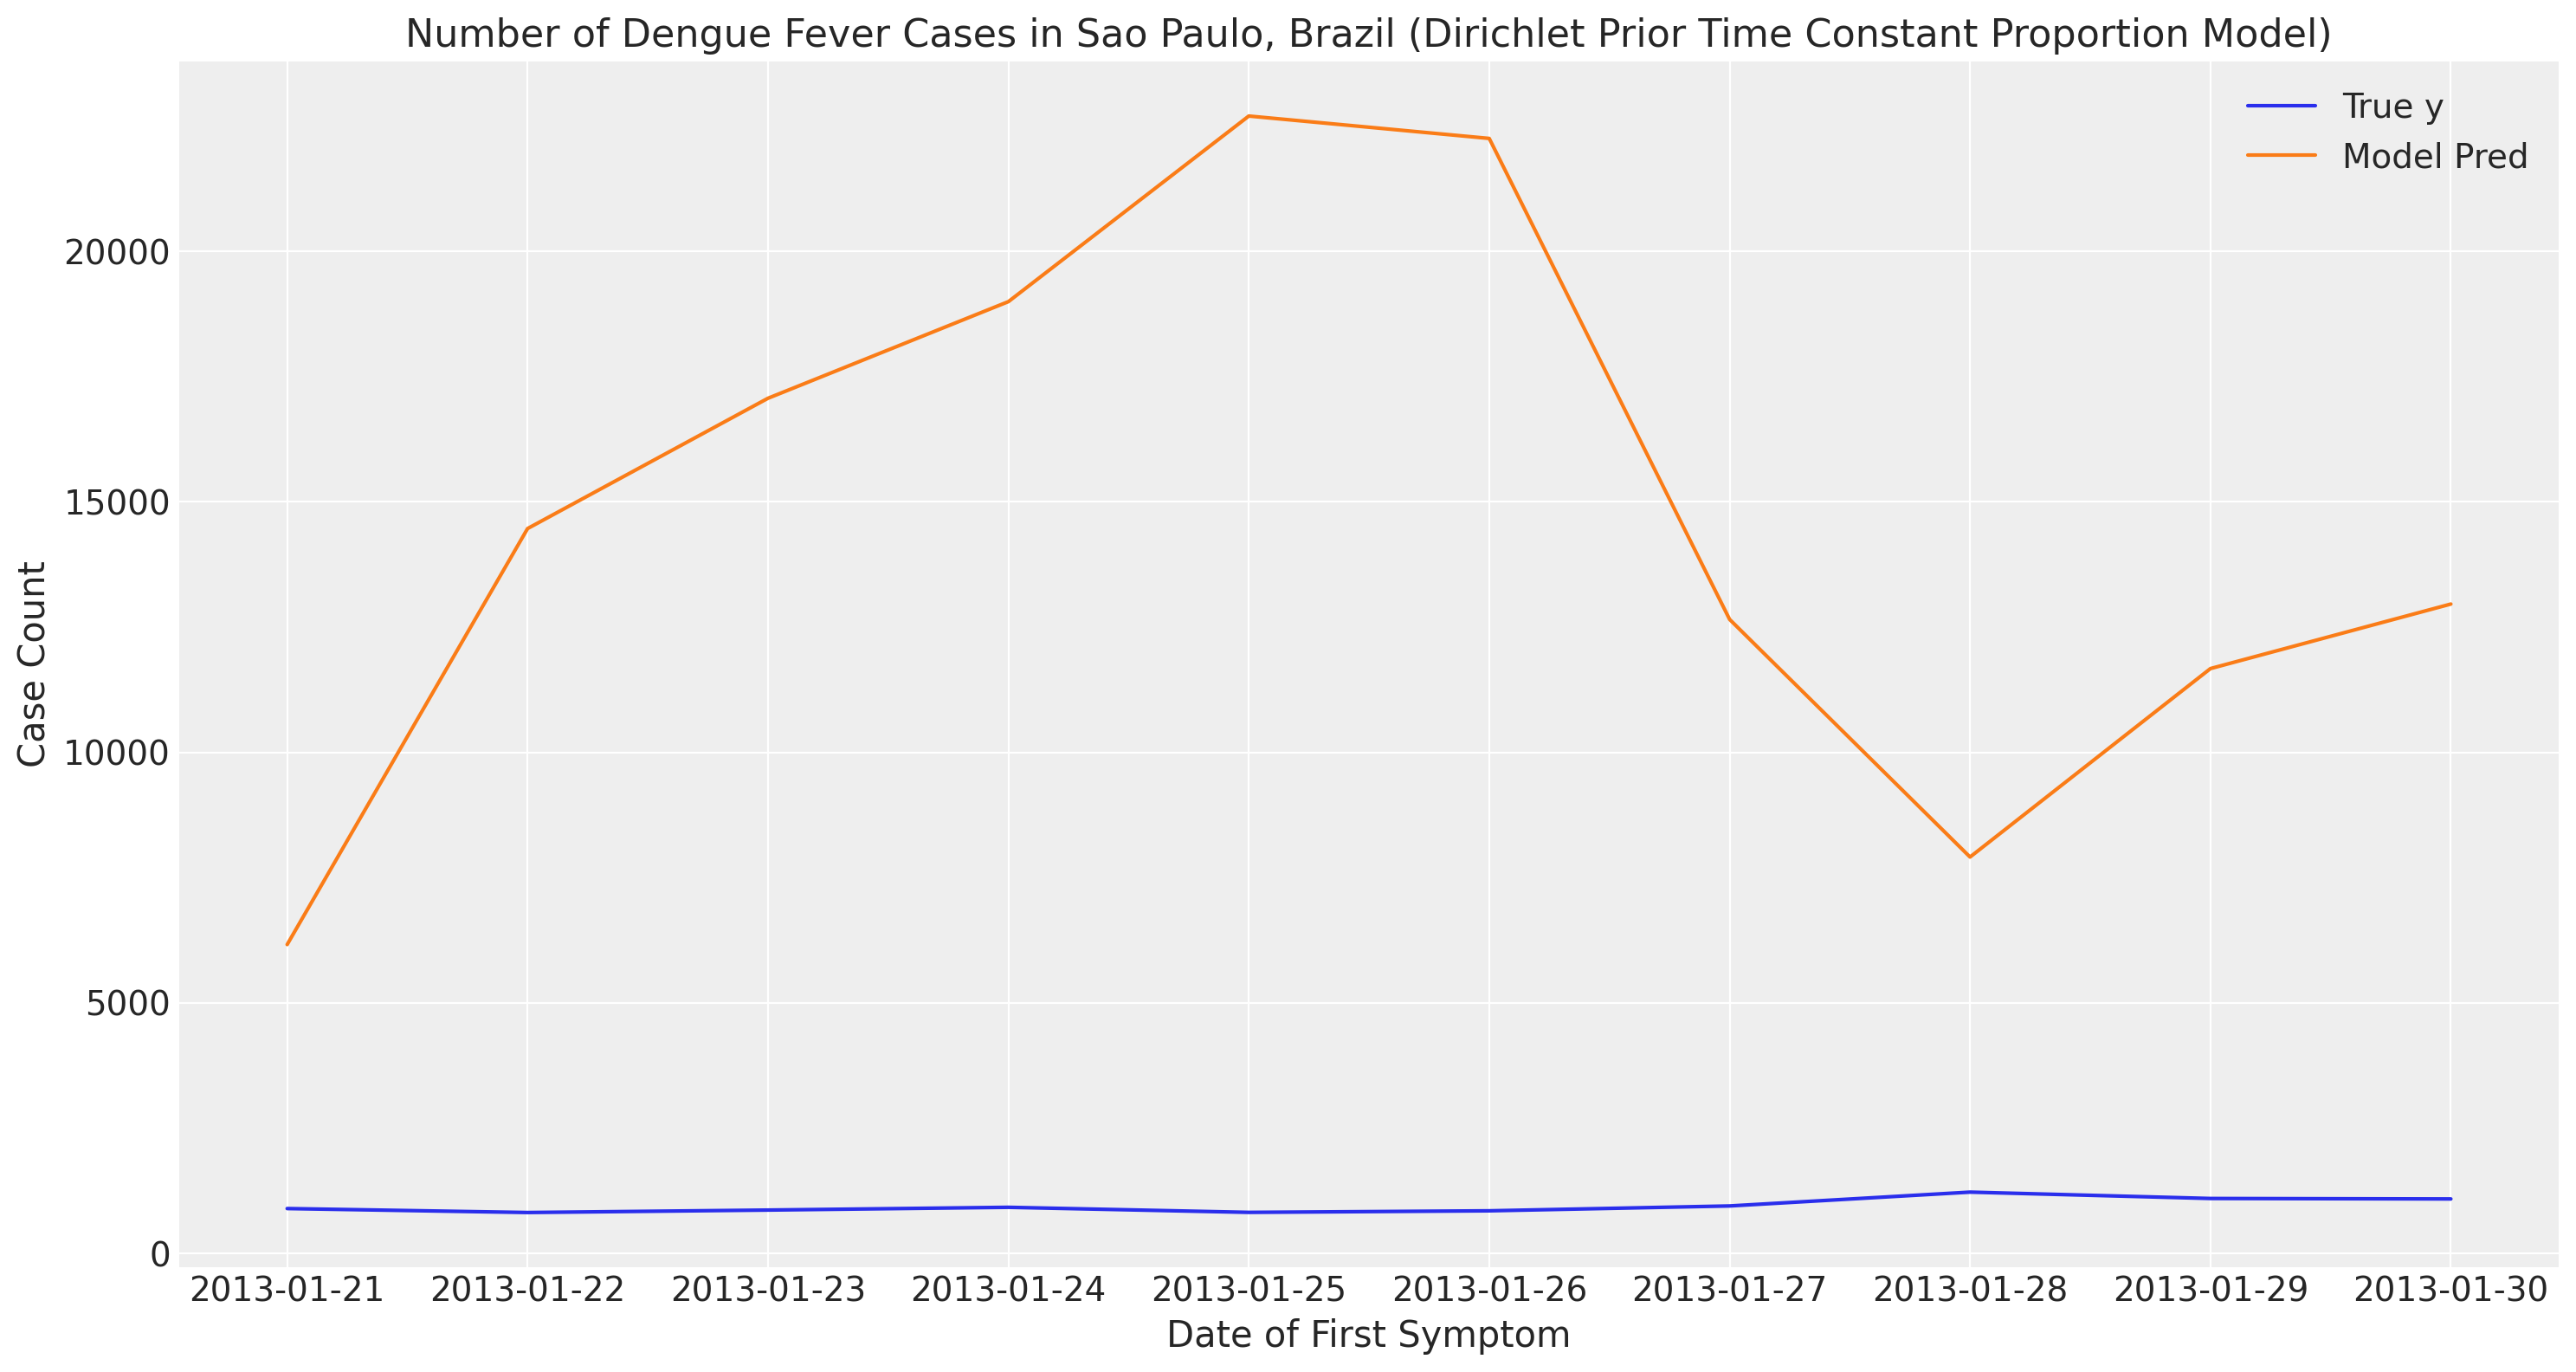

In [236]:
results = np.array(results)
y_model = y_true.iloc[M+model_D:M+model_D+n_points]

# # Plot stacked bars
plt.figure(figsize=(15, 8))
plt.plot(y_model.index, y_model, label="True y")
plt.plot(y_model.index, results, label="Model Pred")
plt.title("Number of Dengue Fever Cases in Sao Paulo, Brazil (Dirichlet Prior Time Constant Proportion Model)")
plt.xlabel("Date of First Symptom")
plt.ylabel("Case Count")
plt.legend()
plt.tight_layout()
plt.show()
